In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsOneClassifier
from sklearn.calibration import CalibratedClassifierCV
# from category_encoders.binary import BinaryEncoder
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lbg
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import pickle
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
import joblib
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# Reference: Code taken from Applied AI Real World Case study Quora Question pair Similarity Problem
def plot_confusion_matrix(test_y, predict_y,num_classes):
    """ Function to plot confusion matrix, precision matrix and recall matrix by taking inputs as y_test and y_predicted"""
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(30,4))
    
    labels = [i for i in range(num_classes)]
 
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap='binary', fmt=".3f")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
def data_splitting(x,target,test_size):
    """Function to split the data into training and testing sets. Takes a dataframe as input,test_size and target variable name, outputs train and test data"""
    X = x.drop(target,axis=1)
    y = x[target]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,stratify=y,random_state=42)
    
    return X_train,X_test,y_train,y_test    

In [ ]:
def model(x_train,y_train,x_test,y_test,clf,params,cv_type):
    
    """ 
    Parameters:
    -----------
    x_train - prre processed training data
    y_train - target of training data
    x_test  - pre processed testing data
    y_test  - target of testing data
    clf     - classifier on which cv needs to be performed
    params  - parameters for cross validdation
    cv_type - type of cross validation 'grid'/'random'
    
    Output:
    -------
    results - It is dictionary will all the results from cross validation and also the predictions
    from best model from cross validation on training and test data
    """
    
    results={}
    results['cv_result'] = cross_validate(x_train,y_train,params,clf,cv_type)
    
    results['best_estimator'] = results['cv_result'].best_estimator_
    results['best_estimator'].fit(x_train,y_train)
    
    results['model'] = CalibratedClassifierCV(results['best_estimator'],method='sigmoid')
    results['model'].fit(x_train,y_train)
       
    results['y_test_pred'] = results['model'].predict(x_test)
    results['y_test_pred_proba'] = results['model'].predict_proba(x_test)
    
    results['y_train_pred'] = results['model'].predict(x_train)
    results['y_train_pred_proba'] = results['model'].predict_proba(x_train)
    
    results['f1_score'] = f1_score(y_test,results['y_test_pred'],average='macro')
    results['log_loss'] = log_loss(y_test,results['y_test_pred_proba'])
    
    return results    

In [ ]:
def cross_validate(x_train,y_train,params,clf,cv_type):
    """Function to perform cross validationo and returns cross validate object
    Parameters:
    -----------
    x_train - array of all transformed features  
    y-train - array of all target variables
    params  - hyperparameters to which model needs to be tuned
    clf     - classifier or regressor on which hyperparameter needs to be performed
    cv_type - type of cross validation eg., "grid" - GridSearchCV / "random" - RandomSearchCV
    
    Return:
    -------
    grdcv - fitted cross validation object
    """
    params = params
    clf = clf
    if cv_type == 'grid':
        grdcv = GridSearchCV(clf,params,cv=9,scoring='f1_weighted',return_train_score=True,verbose=3)
        grdcv.fit(x_train,y_train)
        return grdcv
    elif cv_type == 'random':
        grdcv = RandomizedSearchCV(clf,param_distributions=params,cv=9,scoring='f1_weighted',return_train_score=True,verbose=3)
        grdcv.fit(x_train,y_train)
        return grdcv

In [ ]:
def effective_f1score(target_1,target_2):
    "function to calculate the effective f1_score for predicting target-1 and target-2"
    # Genetic Disorder
    score1 = max(0, 100*target_1)

    # Disorder Subclass
    score2 = max(0, 100*target_2)

    # Final score
    score = (score1/2)+(score2/2)
    return score

<h4>Feature set - 1</h4>
<table>
    <tr>
    <th> Model </th> 
    <th>f1 score target-1</th>
    <th>log loss target-1</th>
    <th>f1 score target-2</th>
    <th>log loss target-2</th>
    <th>effective f1_score</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>          
        <td>0.498316360932994</td>
        <td>0.9287242759229433</td>
        <td>0.2875523346451197</td>
        <td>1.5467993973128242</td>
        <td>39.293434778905684</td>
    </tr>
    <tr>
        <td>RBF SVM</td>                     
        <td>0.4586757449341687</td>
        <td>1.0371195242405382</td>
        <td>0.2896658033509479</td>
        <td>1.5899353999988852</td>
        <td>37.41707741425583</td>
    </tr>
    <tr>
        <td>Random Forest</td>            
        <td>0.46748484246751426</td>
        <td>1.5570730397742654</td>
        <td> 0.2912418491025264 </td>
        <td>1.5420811720180452</td>
        <td>37.93633457850203</td>
    </tr>
    <tr>
        <td>Light GBM</td>                 
        <td>0.46079973869714747</td>
        <td>2.1779389471378385</td>
        <td>0.270308873466899</td>
        <td>1.7823655360828612</td>
        <td>36.55543060820233</td>
    </tr>
    <tr>
        <td>Cat Boost</td>                 
        <td>0.46981190149136104</td>
        <td>3.4281895770624082</td>
        <td>0.27162402935381424</td>
        <td>1.7588206284640553</td>
        <td>37.07179654225877</td>
    </tr>

</table>

<h4>Feature set - 2</h4>
<table>
    <tr>
    <th> Model </th> 
    <th>f1 score target-1</th>
    <th>log loss target-1</th>
    <th>f1 score target-2</th>
    <th>log loss target-2</th>
    <th>effective f1_score</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>          
        <td>0.49701619658390594</td>
        <td>0.9281171469707881</td>
        <td>0.2821210359406281</td>
        <td>1.5375659852663768</td>
        <td>38.956861626226704</td>
    </tr>
    <tr>
        <td>RBF SVM</td>                    
        <td>0.4797094858302178</td>
        <td>0.9111661541860465</td>
        <td>0.29235018635316834</td>
        <td>1.526703719482404</td>
        <td>38.60298360916931</td>
    </tr>
    <tr>
        <td>Random Forest</td>        
        <td>0.47335760275155686</td>
        <td>1.5509585891390523</td>
        <td>0.275868237982473</td>
        <td>1.5421805015870924</td>
        <td>37.461292036701494 </td>
    </tr>
    <tr>
        <td>Light GBM</td>               
        <td>0.4678071526154732</td>
        <td>2.0201087541420173</td>
        <td>0.27019243457343056</td>
        <td>1.7804974683942474</td>
        <td>36.89997935944518</td>
    </tr>
    <tr>
        <td>Cat Boost</td>                
        <td>0.46447355704450044</td>
        <td>2.5773749694810038</td>
        <td>0.26861479469372324</td>
        <td>1.7824791917080318</td>
        <td>36.65441758691119</td>
    </tr>

</table>

* I have observed that model is performing better when the null values are removed instead of imputing them for classifying target_1
* below is the randomforest classifier trained on important features without upsampling, this gave significant rise in weighted_f1_score. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Retraining model with dropping null values from the dataset

In [ ]:
target_1_impfeatures = set(['num_symptoms','genes_in_mother_side','inherited_from_father','maternal_gene','paternal_gene','blood_cell_count','avg_parents_age','FE_1','white_blood_cell_count','patient_age','num_symptoms','blood_test_result'])
target_2_impfeatures = set(['blood_cell_count','avg_parents_age','white_blood_cell_count','symptom_1','symptom_2','symptom_3','symptom_4','symptom_5','FE_1','patient_age','num_symptoms','genes_in_mother_side','inherited_from_father','maternal_gene','paternal_gene'])
important_features = set(['target_1','target_2'])
important_features=important_features.union(target_1_impfeatures.union(target_2_impfeatures))

In [ ]:
drop_df = pd.read_csv('dropna_train.csv')
drop_df.drop('Unnamed: 0',axis=1,inplace=True)
drop_df.head()

,patient_age,genes_in_mother_side,inherited_from_father,maternal_gene,paternal_gene,blood_cell_count,institute_name,location_of_institute,status,respiratory_rate,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,num_symptoms,FE_1,avg_parents_age,target_1,target_2
0,11.0,No,No,Yes,No,5.209058,Lemuel Shattuck Hospital,"125 NASHUA ST\nCENTRAL, MA 02114\n(42.36764789...",Alive,Tachypnea,...,1.0,1.0,1.0,0.0,1.0,4.0,4.00,44.5,0,6
1,4.0,No,Yes,Yes,Yes,4.752272,Shriners Burns Institute,"1200 Centre St\nRoslindale, MA 02131\n(42.2973...",Alive,Tachypnea,...,0.0,0.0,1.0,1.0,1.0,3.0,1.50,43.0,1,3
2,1.0,Yes,Yes,No,No,4.612265,Not applicable,-,Deceased,Normal (30-60),...,1.0,1.0,0.0,1.0,0.0,3.0,3.00,53.0,0,6
3,6.0,Yes,No,Yes,No,4.620420,Not applicable,-,Alive,Tachypnea,...,1.0,0.0,1.0,0.0,1.0,3.0,0.75,30.5,0,6
4,10.0,Yes,Yes,Yes,No,4.751452,Massachusetts Eye & Ear Infirmary,"44 BINNEY ST\nFENWAY/KENMORE, MA 02115\n(42.33...",Deceased,Normal (30-60),...,1.0,1.0,0.0,0.0,0.0,2.0,0.50,48.5,0,7


In [ ]:
drop_df.drop(['institute_name'],axis=1,inplace=True)

In [ ]:
drop_df = drop_df[important_features]

In [ ]:
X_train,X_test,y_train,y_test = data_splitting(drop_df,['target_1','target_2'],0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5096, 16)
(1274, 16)
(5096, 2)
(1274, 2)


In [ ]:
cardinality_eq_two,cardinality_gt_two = [],[]
for i in X_train.select_dtypes(include=['object']).columns:
    if X_train[i].nunique()==2:
        cardinality_eq_two.append(i)
    elif X_train[i].nunique()>2:
        cardinality_gt_two.append(i)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
# binary_encoder = BinaryEncoder(cols=cardinality_gt_two)
# standard_scaler = StandardScaler()

In [ ]:
# from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

In [ ]:
numerical_cols = [i for i in X_train.select_dtypes(include=['float64','int64']).columns if i != 'target_1' or i!='target_2']

In [ ]:
def numerical_features(x):
  return x.values

In [ ]:
categorical = cardinality_eq_two+cardinality_gt_two
# selector = SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=1000))

In [ ]:
pre_processor_1 = ColumnTransformer([
    ('one-hot-encoder', one_hot_encoder, categorical),
    ('numerical',FunctionTransformer(func=numerical_features),numerical_cols)
    ])
pre_processor_1.fit(X_train)

ColumnTransformer(transformers=[('one-hot-encoder', OneHotEncoder(sparse=False),
                                 ['genes_in_mother_side', 'maternal_gene',
                                  'inherited_from_father', 'paternal_gene',
                                  'blood_test_result'])])

In [ ]:
pre_processor_1.fit_transform(X_train)

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
rf = pickle.load(open('/content/drive/MyDrive/MachineLearning/randomforest_.pkl','rb'))

In [ ]:
print('BaseLine Random Forest')
print('f1-score')
print(f1_score(y_test.values[:,0],rf.predict(X_test),average='weighted'))

BaseLine Random Forest
f1-score
0.6343936576866197


In [ ]:
print('BaseLine RandomForest')
print(classification_report(y_test.values[:,0],rf.predict(X_test)))

BaseLine RandomForest
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       647
           1       0.42      0.36      0.39       138
           2       0.61      0.49      0.55       489

    accuracy                           0.64      1274
   macro avg       0.57      0.56      0.56      1274
weighted avg       0.63      0.64      0.63      1274



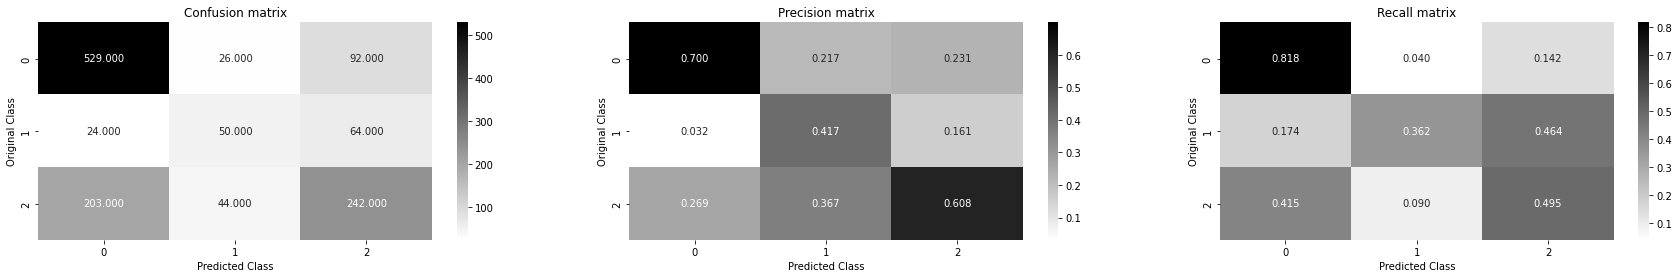

In [ ]:
plot_confusion_matrix(y_test.values[:,0],rf.predict(X_test),3)

* Random Forest model trained on dataset which was imputed has 0.46 f1 score.
* Later instead of imputing the null values I have dropped all the rows with null values and trained a oneVsRest Random Forest classifier which resulted in increase in macro f1 score when compared to previous model and weighted f1 score in 0.63

# Training RandomForest Classifier Model on dataset without any imputations

In [ ]:
pipe = Pipeline([('pre_processor',pre_processor_1),('rf',OneVsRestClassifier(estimator = RandomForestClassifier()) )])

In [ ]:
params = {'rf__estimator__n_estimators' : [500,1000,2000,3000],'rf__estimator__min_samples_split' : [2, 5, 10],'rf__estimator__min_samples_leaf' : [1, 2, 4]}

In [ ]:
baseline1 = model(X_train,y_train.values[:,0],X_test,y_test.values[:,0],pipe,params,cv_type="random")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END rf__estimator__min_samples_leaf=2, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=2000;, score=(train=0.988, test=0.629) total time=  31.3s


KeyboardInterrupt: ignored

# Error Analysis



In [ ]:
baseline_model_f1_score = f1_score(y_test.values[:,0],rf.predict(X_test),average='weighted')

In [ ]:
# rf = baseline1['model']
test_set = X_test.copy()

In [ ]:
test_set['target_1'] = y_test.values[:,0]
test_set['target_1_pred'] = rf.predict(X_test)
test_set['is_error'] = np.where(test_set['target_1']==test_set['target_1_pred'],0,1)

In [ ]:
test_set

,symptom_3,symptom_1,paternal_gene,blood_test_result,patient_age,inherited_from_father,blood_cell_count,symptom_4,symptom_5,maternal_gene,num_symptoms,genes_in_mother_side,FE_1,avg_parents_age,white_blood_cell_count,symptom_2,target_1,target_1_pred,is_error
4473,1.0,1.0,No,abnormal,8.0,No,4.950107,1.0,0.0,No,3.0,Yes,3.00,41.5,3.189314,0.0,0,0,0
4733,0.0,0.0,No,inconclusive,9.0,No,4.384045,1.0,0.0,No,1.0,No,0.20,50.0,6.469576,0.0,2,2,0
6291,1.0,1.0,Yes,slightly abnormal,2.0,No,4.535623,1.0,1.0,Yes,5.0,No,1.25,38.0,3.000000,1.0,0,1,1
6029,0.0,1.0,Yes,normal,13.0,No,4.901324,1.0,1.0,Yes,4.0,Yes,2.00,37.5,10.980827,1.0,2,2,0
2540,1.0,1.0,Yes,inconclusive,6.0,No,4.962777,1.0,0.0,Yes,3.0,Yes,3.00,42.5,6.048378,0.0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,1.0,1.0,No,slightly abnormal,13.0,Yes,4.632641,1.0,0.0,Yes,4.0,No,0.80,34.5,6.142274,1.0,1,2,1
823,1.0,1.0,No,inconclusive,10.0,Yes,4.845721,1.0,1.0,No,5.0,Yes,1.25,39.0,8.804378,1.0,0,1,1
4678,1.0,0.0,No,normal,14.0,Yes,5.173994,1.0,0.0,Yes,3.0,Yes,0.75,45.5,8.461528,1.0,2,0,1
6104,1.0,0.0,Yes,abnormal,5.0,Yes,4.998214,1.0,0.0,Yes,2.0,No,0.50,32.5,3.993526,0.0,0,0,0


In [ ]:
wrong_predictions = test_set.loc[test_set['is_error']==1]
correct_predictions = test_set.loc[test_set['is_error']==0]

In [ ]:
wrong_predictions.loc[(wrong_predictions.target_1==2) & (wrong_predictions.target_1_pred==0)]

,symptom_3,symptom_1,paternal_gene,blood_test_result,patient_age,inherited_from_father,blood_cell_count,symptom_4,symptom_5,maternal_gene,num_symptoms,genes_in_mother_side,FE_1,avg_parents_age,white_blood_cell_count,symptom_2,target_1,target_1_pred,is_error
2540,1.0,1.0,Yes,inconclusive,6.0,No,4.962777,1.0,0.0,Yes,3.0,Yes,3.00,42.5,6.048378,0.0,2,0,1
3767,1.0,1.0,Yes,abnormal,10.0,Yes,4.835300,1.0,0.0,Yes,3.0,Yes,1.50,43.5,12.000000,0.0,2,0,1
1318,1.0,1.0,Yes,slightly abnormal,7.0,Yes,5.000454,0.0,1.0,No,3.0,Yes,0.75,36.0,4.087516,0.0,2,0,1
3382,0.0,1.0,No,normal,7.0,No,4.888130,0.0,0.0,No,2.0,Yes,0.50,30.5,8.979276,1.0,2,0,1
4617,1.0,0.0,No,abnormal,1.0,Yes,5.017190,1.0,1.0,Yes,3.0,No,1.50,42.5,3.000000,0.0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,0.0,1.0,No,slightly abnormal,4.0,No,4.968730,0.0,1.0,Yes,3.0,Yes,0.60,32.0,10.049939,1.0,2,0,1
3206,0.0,1.0,No,slightly abnormal,3.0,No,4.817959,0.0,0.0,Yes,2.0,Yes,0.50,52.0,6.655620,1.0,2,0,1
5335,1.0,1.0,Yes,inconclusive,14.0,No,5.099380,1.0,0.0,Yes,3.0,Yes,1.50,50.0,7.992025,0.0,2,0,1
2081,0.0,0.0,No,inconclusive,6.0,No,4.879793,1.0,0.0,Yes,2.0,No,0.50,45.5,6.213779,1.0,2,0,1


In [ ]:
correct_predictions.loc[correct_predictions.target_1==2]

,symptom_3,symptom_1,paternal_gene,blood_test_result,patient_age,inherited_from_father,blood_cell_count,symptom_4,symptom_5,maternal_gene,num_symptoms,genes_in_mother_side,FE_1,avg_parents_age,white_blood_cell_count,symptom_2,target_1,target_1_pred,is_error
4733,0.0,0.0,No,inconclusive,9.0,No,4.384045,1.0,0.0,No,1.0,No,0.200000,50.0,6.469576,0.0,2,2,0
6029,0.0,1.0,Yes,normal,13.0,No,4.901324,1.0,1.0,Yes,4.0,Yes,2.000000,37.5,10.980827,1.0,2,2,0
2901,1.0,0.0,Yes,inconclusive,12.0,Yes,4.793283,1.0,1.0,No,4.0,No,1.333333,35.5,10.577894,1.0,2,2,0
4467,0.0,0.0,Yes,abnormal,9.0,No,4.950716,0.0,0.0,Yes,1.0,No,0.500000,35.0,11.048624,1.0,2,2,0
4721,0.0,0.0,Yes,abnormal,14.0,No,4.901437,0.0,1.0,No,1.0,Yes,0.200000,22.5,10.232870,0.0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,1.0,0.0,No,normal,7.0,No,4.696928,0.0,0.0,No,1.0,No,0.200000,25.0,9.471620,0.0,2,2,0
2981,1.0,0.0,No,normal,9.0,No,4.646310,0.0,0.0,No,1.0,No,0.333333,34.0,6.437596,0.0,2,2,0
4271,0.0,0.0,Yes,abnormal,5.0,No,5.185115,1.0,0.0,Yes,1.0,No,0.500000,45.5,9.796373,0.0,2,2,0
3213,1.0,0.0,No,slightly abnormal,5.0,No,4.803987,1.0,1.0,No,4.0,Yes,1.333333,30.5,7.405118,1.0,2,2,0


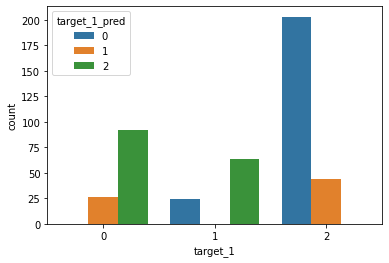

In [ ]:
sns.countplot(data=wrong_predictions,x='target_1',hue='target_1_pred')

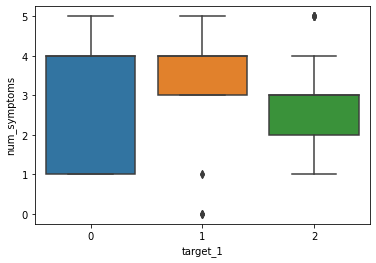

In [ ]:
sns.boxplot(data=wrong_predictions,x='target_1',y='num_symptoms')

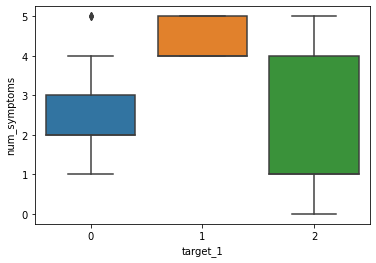

In [ ]:
sns.boxplot(data=correct_predictions,x='target_1',y='num_symptoms')

* remove points with num_symptoms = 5 and class 0 
* remove points with num_symptoms = 3 and class 1

In [ ]:
drop_df = drop_df.drop(index=drop_df.loc[(drop_df.num_symptoms==5) & (drop_df.target_1==0)].index)

In [ ]:
drop_df = drop_df.drop(index=drop_df.loc[(drop_df.num_symptoms==3) & (drop_df.target_1==1)].index)

In [ ]:
drop_df = drop_df[important_features]

In [ ]:
X_train,X_test,y_train,y_test = data_splitting(drop_df,['target_1','target_2'],0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4915, 16)
(1229, 16)
(4915, 2)
(1229, 2)


# Model performance after removing some points from the dataset 

In [ ]:
rf_ = pickle.load(open('/content/drive/MyDrive/MachineLearning/randomforest_0.65.pkl','rb'))

In [ ]:
# print('BaseLine Random Forest')
# print('f1-score')
# print(f1_score(d.values[:,0],rf.predict(b),average='weighted'))
print('Model After removing some data points')
print('f1-score')
print(f1_score(y_test.values[:,0],rf_.predict(X_test),average='weighted'))

Model After removing some data points
f1-score
0.6566274449716273


In [ ]:
# print('BaseLine RandomForest')
# print(classification_report(d.values[:,0],rf.predict(b)))

In [ ]:
print('Model After removing some data points')
print(classification_report(y_test.values[:,0],rf_.predict(X_test)))

Model After removing some data points
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       627
           1       0.56      0.55      0.55       113
           2       0.62      0.48      0.55       489

    accuracy                           0.67      1229
   macro avg       0.63      0.62      0.62      1229
weighted avg       0.66      0.67      0.66      1229



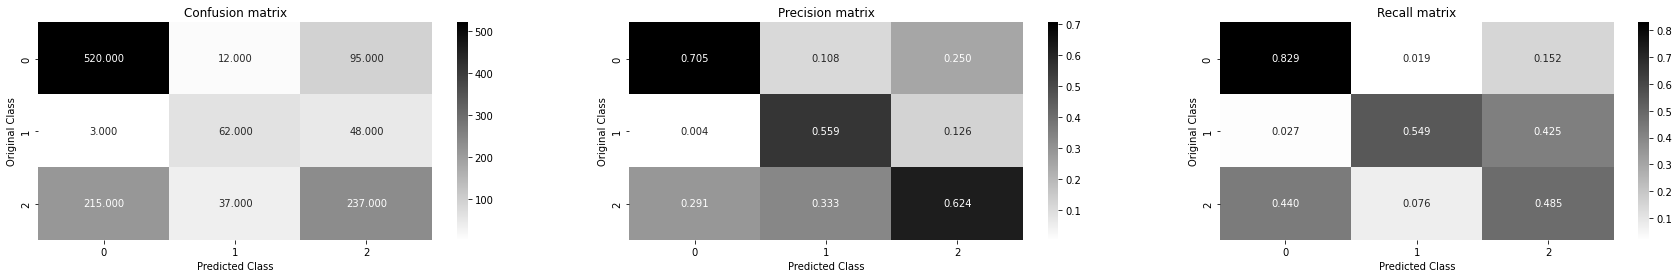

In [ ]:
plot_confusion_matrix(y_test.values[:,0],rf_.predict(X_test),3)

* We can see that a large number of points belonging to class_2 are being misclassified as class_0

#### Observation

* When I have trained the model for the first time it has 0.63 weighted f1_score.
* After error analysis I have removed point which are having num_symptoms = 3 target_1 = 1 and num_symptoms = 5 target_1=0 then the random forest model trained and performed better on the test set and weighted f1_score was impoved significantly to 0.65

In [ ]:
train_proba = rf.predict_proba(X_train)
test_proba = rf.predict_proba(X_test)

In [ ]:
X_train['pred_target_1'] = rf.predict(X_train)

In [ ]:
X_train['proba_0'] = train_proba[:,0]
X_train['proba_1'] = train_proba[:,1]
X_train['proba_2'] = train_proba[:,2]

In [ ]:
X_test['pred_target_1'] = rf.predict(X_test)

In [ ]:
X_test['proba_0'] = test_proba[:,0]
X_test['proba_1'] = test_proba[:,1]
X_test['proba_2'] = test_proba[:,2]

* Now to predict target_2 I have added predicted probabilities of target_1 and predicted values of target_1 in the training and test set.

# Training RandomForest Classifier Model on dataset without any imputations for target_2 prediction

In [ ]:
numerical_cols = [i for i in X_train.select_dtypes(include=['float64','int64']).columns if i != 'target_1' or i!='target_2']

In [ ]:
def numerical_features(x):
  return x.values

In [ ]:
pre_processor_1 = ColumnTransformer([
    ('one-hot-encoder', one_hot_encoder, categorical),
    ('numerical',FunctionTransformer(func=numerical_features),numerical_cols)
    ])
pre_processor_1.fit(X_train)

ColumnTransformer(transformers=[('one-hot-encoder', OneHotEncoder(sparse=False),
                                 ['paternal_gene', 'inherited_from_father',
                                  'maternal_gene', 'genes_in_mother_side',
                                  'blood_test_result']),
                                ('numerical',
                                 FunctionTransformer(func=<function numerical_features at 0x7f318b6a8170>),
                                 ['symptom_3', 'symptom_1', 'patient_age',
                                  'blood_cell_count', 'symptom_4', 'symptom_5',
                                  'num_symptoms', 'FE_1', 'avg_parents_age',
                                  'white_blood_cell_count', 'symptom_2',
                                  'pred_target_1', 'proba_0', 'proba_1',
                                  'proba_2'])])

In [ ]:
params = {'rf__estimator__n_estimators' : [500,1000,2000,3000],'rf__estimator__min_samples_split' : [2, 5, 10],'rf__estimator__min_samples_leaf' : [1, 2, 4]}

In [ ]:
pipe = Pipeline([('pre_processor',pre_processor_1),('rf',OneVsRestClassifier(estimator = RandomForestClassifier()) )])

In [ ]:
baseline1 = model(X_train,y_train.values[:,1],X_test,y_test.values[:,1],pipe,params,cv_type="random")

Fitting 9 folds for each of 10 candidates, totalling 90 fits
[CV 1/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=500;, score=(train=0.997, test=0.638) total time=  23.9s
[CV 2/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=500;, score=(train=0.997, test=0.621) total time=  24.0s
[CV 3/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=500;, score=(train=0.996, test=0.662) total time=  24.4s
[CV 4/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=500;, score=(train=0.997, test=0.623) total time=  24.2s
[CV 5/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estimator__n_estimators=500;, score=(train=0.996, test=0.646) total time=  24.0s
[CV 6/9] END rf__estimator__min_samples_leaf=1, rf__estimator__min_samples_split=5, rf__estima

In [ ]:
print(f1_score(y_test.values[:,1],baseline1['model'].predict(X_test),average='weighted'))

0.62237349430751


In [ ]:
print(classification_report(y_test.values[:,1],baseline1['model'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.67      0.67      0.67         6
           2       0.85      0.82      0.83       223
           3       0.73      0.83      0.78        96
           4       0.50      0.36      0.42        83
           5       0.83      0.48      0.61        21
           6       0.61      0.62      0.61       318
           7       0.53      0.48      0.50       288
           8       0.53      0.68      0.60       183

    accuracy                           0.63      1229
   macro avg       0.65      0.59      0.61      1229
weighted avg       0.63      0.63      0.62      1229



In [ ]:
plot_confusion_matrix(y_test.values[:,1],baseline1['model'].predict(X_test),9)

* When compared with the random forest model trained on imputed dataset macro f1 score is 0.29.
* there is a significant bump in macro f1 score when model was trained with oneVsRest RandomForest classifier on data where the null values are dropped which is 0.61

In [ ]:
pickle.dump(baseline1['model'],open('/content/drive/MyDrive/MachineLearning/rf_1.pkl','wb'))